# Greatreads
### ML Binary Classification of Great Books Using Data from Goodreads' API

### What?

This is a data set of the first 50,000 book ids pulled from Goodreads' API on July 30th, 2020. A few thousand ids did not make it through because the book id was changed, the URL or API broke, or the information was stored in an atypical format.

### Why?

From the reader's perspective, books are a multi-hour commitment of learning and leisure (they don't call it **Good**reads for nothing). From the author's and publisher's perspectives, books are a way of living (with some learning and leisure too). In both cases, knowing which factors explain and predict great books will save you time and money. Because while different people have different tastes and values, knowing how a book is rated in general is a sensible starting point. You can always update it later.


# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import category_encoders as ce
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
import eli5
from eli5.sklearn import PermutationImportance

/Users/RyanKoul/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/RyanKoul/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load and Inspect Data

In [2]:
PATH = '/Users/RyanKoul/goodreads/'
df = pd.read_json(PATH + 'book_data.json')

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41732 entries, 0 to 41731
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 41732 non-null  int64  
 1   title              41732 non-null  object 
 2   isbn               41090 non-null  object 
 3   isbn13             41220 non-null  float64
 4   publication_year   34933 non-null  float64
 5   publication_month  33195 non-null  float64
 6   publication_day    32453 non-null  float64
 7   publisher          34877 non-null  object 
 8   language_code      17040 non-null  object 
 9   average_rating     41732 non-null  float64
 10  num_pages          32551 non-null  float64
 11  format             34584 non-null  object 
 12  rating_dist        41732 non-null  object 
 13  review_count       41732 non-null  int64  
 14  genres             41732 non-null  object 
 15  author             41732 non-null  object 
dtypes: float64(6), int64(2

,id,title,isbn,isbn13,publication_year,publication_month,publication_day,publisher,language_code,average_rating,num_pages,format,rating_dist,review_count,genres,author
0,1,Harry Potter and the Half-Blood Prince (Harry ...,None,NaN,2006.0,9.0,16.0,Scholastic Inc.,eng,4.57,652.0,Paperback,5:1571991|4:562859|3:161511|2:25569|1:10094|to...,37317,"[fantasy, favorites, currently-reading, young-...",J.K. Rowling
1,2,Harry Potter and the Order of the Phoenix (Har...,0439358078,9.780439e+12,2004.0,9.0,NaN,Scholastic Inc.,eng,4.50,870.0,Paperback,5:1519180|4:612167|3:214032|2:37397|1:12717|to...,39934,"[currently-reading, fantasy, favorites, young-...",J.K. Rowling
2,3,Harry Potter and the Sorcerer's Stone (Harry P...,None,NaN,2003.0,11.0,1.0,Scholastic Inc,eng,4.47,309.0,Hardcover,5:4352366|4:1538156|3:575588|2:132291|1:110301...,106769,"[to-read, currently-reading, fantasy, favorite...",J.K. Rowling
3,4,Harry Potter and the Chamber of Secrets (Harry...,0439554896,9.780440e+12,2003.0,11.0,1.0,Scholastic,eng,4.42,352.0,Hardcover,5:1530316|4:715867|3:291693|2:49748|1:12068|to...,49924,"[to-read, currently-reading, fantasy, favorite...",J.K. Rowling
4,5,Harry Potter and the Prisoner of Azkaban (Harr...,043965548X,9.780440e+12,2004.0,5.0,1.0,Scholastic Inc.,eng,4.57,435.0,Mass Market Paperback,5:1787074|4:639613|3:197027|2:25228|1:10423|to...,52362,"[fantasy, favorites, young-adult, fiction, har...",J.K. Rowling


## Display Target
The target is not normally centered at the middle (at 3, halfway between 1 and 5). Instead, it's centered at 4 stars. Aside from some outlier books with 0 ratings, the 5 point scale is effecitvely a 3 point scale from 2-5, perhaps due to rating inflation.

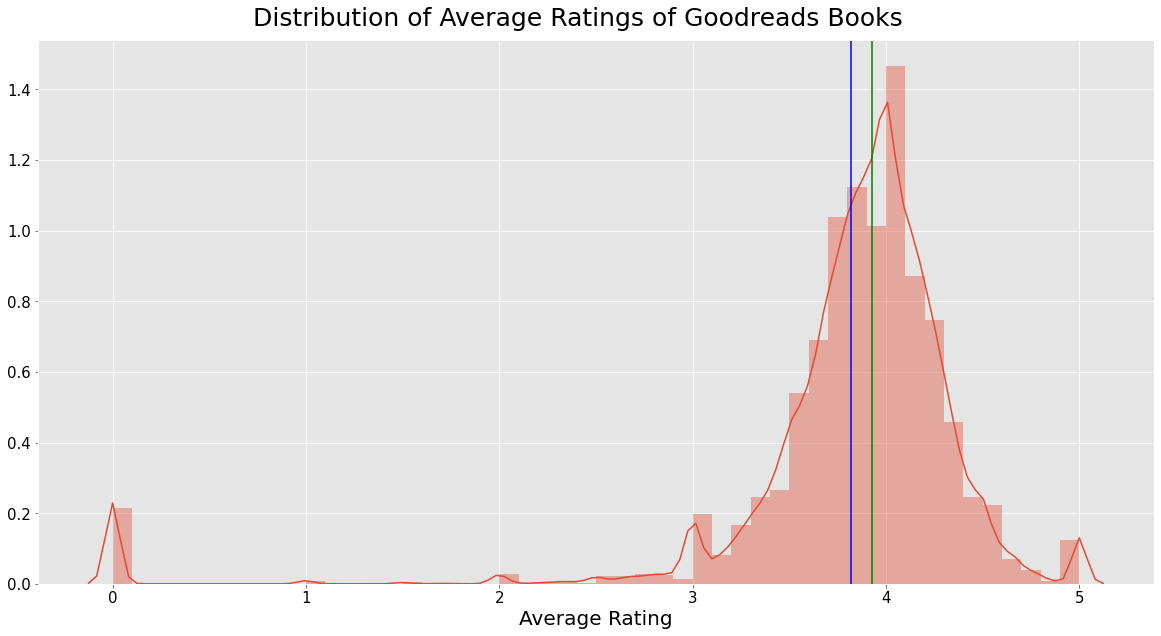

In [3]:
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
sns.distplot(df['average_rating'])
plt.axvline(df['average_rating'].mean(), color='b')
plt.axvline(df['average_rating'].median(), color='g')

plt.figtext(.5,.9,'Distribution of Average Ratings of Goodreads Books', 
            fontsize=25, ha='center')
plt.xticks(fontsize=15, color='k')
plt.yticks(fontsize=15, color='k')
plt.xlabel('Average Rating', fontsize=20, color='k')
plt.show()

# Pre-processing
We'll define and describe some key functions below, but we'll actually call them and perform other cleaning in one big wrangle function later.

### Wilson Lower Bound
$\frac{\bar x+z^2/2n-z\sqrt{\bar x(1-\bar x)/n+z^2/4n^2}}{1+z^2/n}$

A rating of 4 stars based on 20 reviews and a rating of 4 stars based on 20,000 reviews are not equal. The rating based on more reviews has less uncertainty about it and is therefore a more reliable estimate of the "true" rating. We must transform average ratings to reflect this in order to properly define and predict great books. In other words, we must put a penalty on uncertainty.

We'll do this by calculating a [Wilson Lower Bound](https://www.evanmiller.org/how-not-to-sort-by-average-rating.html), where we estimate the confidence interval of a particular rating and take its lower bound as the new rating. Ratings based on tens of thousands of reviews will barely be affected because their confidence intervals are tighter. Ratings based on fewer reviews, however, have wider confidence intervals and will be scaled down more. 

**Note**: We modify the formula because our data is calculated from a 5-point system, not a binary system as described by Wilson. Specifically, we decrement average stars by 1 for a conservative estimate of the true non-inflated rating, and then normalize it. If this penalty is too harsh or too light, more ratings will over time raise or lower the book's rating, respectively. That is, with more information, this adjustment is self-correcting.

In [4]:
def wilson_lower_bound(average_rating, n, confidence=0.95):
    """
    Returns the lower bound of the "true" 5-star rating. Used to scale down 
    ratings with fewer observations due to the greater uncertainty (wider
    confidence interval).
    Parameters:
    average_rating: the average book rating, assumed to be out of 5
    n: the total number of ratings
    confidence: statistical confidence level, default 95%
    """
    if n == 0:
        return 0                               # Cannot scale down ratings if 
                                               # there are no ratings
    
    z = st.norm.ppf(1 - (1 - confidence) / 2)  # Z-score, default 1.96
    x_hat = (average_rating - 1) / 4           # Decrement and normalize
    wlb = (
        x_hat + z*z/(2*n) - z * np.sqrt((x_hat *(1-x_hat)+z*z/(4*n))/n))/(1+z*z/n)

    return 1 + (4 * wlb)                       # Add to 1 because minimum rating of 
                                               # rated books is 1 star out of 

### Genres
Goodreads' API returns 'shelves', which encompass actual genres like "science-fiction" and user-created categories like "to-read". We extracted only the 5 most popular shelves when pulling the data to limit this kind of clean-up; here, we'll finish the job. 

After some inspection, we see that these substrings represent the bulk of non-genre shelves. We'll filter them out using a regular expression. **Note**: Adjacent strings inside parantheses are joined at compile time.

In [5]:
def filter_fake_genres(genre_list):
    """ 
    Filters out "genres" that aren't really genres.
    Case doesn't matter since all Goodreads "shelves"
    are lower case.

    Syntax:
    ^ = start of line/string
    .* = any character except \n (0 or more times)
    (...|...) = unique substrings separated by |
    ? = preceding character is optional for match
    $  = end of line/string
    """
    genre_regex = re.compile(
        r'^.*(book|to-|read|my-|favou?rite|own|audio|library|kindle|english|default|'
        'calibre|next|want|[0-9]|best).*$')
    cleaned_genres = [genre for genre in genre_list 
                      if not re.search(genre_regex, genre)]
    
    try:                             # Get most popular real genre from cleaned list
        return cleaned_genres[0]   
    except:                          # But if it's empty, return 'unknown'
        return 'unknown'

### All-in-one Cleaning

In [6]:
def wrangle(X):
    """
    Accepts and cleans a DataFrame. Returns train set.
    """
    
    # Make shallow copy to avoid destroying original DataFrame
    X = X[:]
    
    
    # TITLE
    # Since ratings and reviews are for all editions, drop multiple editions
    # of the same book so every book corresponds to 1 and only 1 row
    X = X[~X.duplicated(subset='title')]
    
    # Engineer two features based on title
    X['title_length_in_characters'] = X['title'].apply(lambda title: len(title))
    X['title_length_in_words'] = X['title'].apply(lambda title: len(title.split()))
    
    
    # RATING DIST 
    # Regex lookbehind to extract only total rating count, then cast as int
    X['total_ratings'] = X['rating_dist'].apply(
    lambda row: int(re.findall(r'(?<=:)(\w+)', row)[5]))
    
    
    # TOTAL RATINGS
    # Filter out books with less than 20 ratings.
    X = X[X['total_ratings'] >= 20]
                     
    
    # AUTHOR
    # Strip all leading and trailing whitespace and any excess middle white space
    X['author'] = [' '.join(author.split()) 
                    for author in X['author']]
    
    
    # GENRES
    # Filter out uninformative genres like "to-read", then extract the most popular one
    X['genres'] = [filter_fake_genres(genre_list) 
                   for genre_list in X['genres']]
    
    
    # HIGH CARDINALITY
    # These unique-values columns may come in handy later if we want to merge with another dataset.
    # For now, we can drop them.
    high_cardinality = ['id', 'isbn', 'isbn13', 'title']
    X = X.drop(columns=high_cardinality)

     
    # AVERAGE RATING
    # Scale down average ratings based on their uncertainty, then assign them to a new column
    adjusted_averages = []
    for i in range(len(X)):
        avg = X['average_rating'].iloc[i]
        total = X['total_ratings'].iloc[i]
        adjusted_averages.append(wilson_lower_bound(avg, total))
    
    X['adjusted_average_rating'] = adjusted_averages

    
    # FEATURE ENGINEER TARGET
    # Make 'great' column for top 20% of books based on wilson-adjusted average rating
    top_20_percent = np.percentile(X['adjusted_average_rating'], q=80)
    X['great'] = X['adjusted_average_rating'] >= top_20_percent
    

    return X

train = wrangle(df)

### Compare Unadjusted and Adjusted Average Ratings
Numerically, the central measures of tendency of mean (in blue) and median (in green) slightly decrease, and the variance significantly decreases.

Visually, we can see the rating adjustment in the much smoother and wider distribution (although note that the x-axis is truncated). This is from eliminating outlier books with no or very few ratings, and scaling down ratings with high uncertainty.

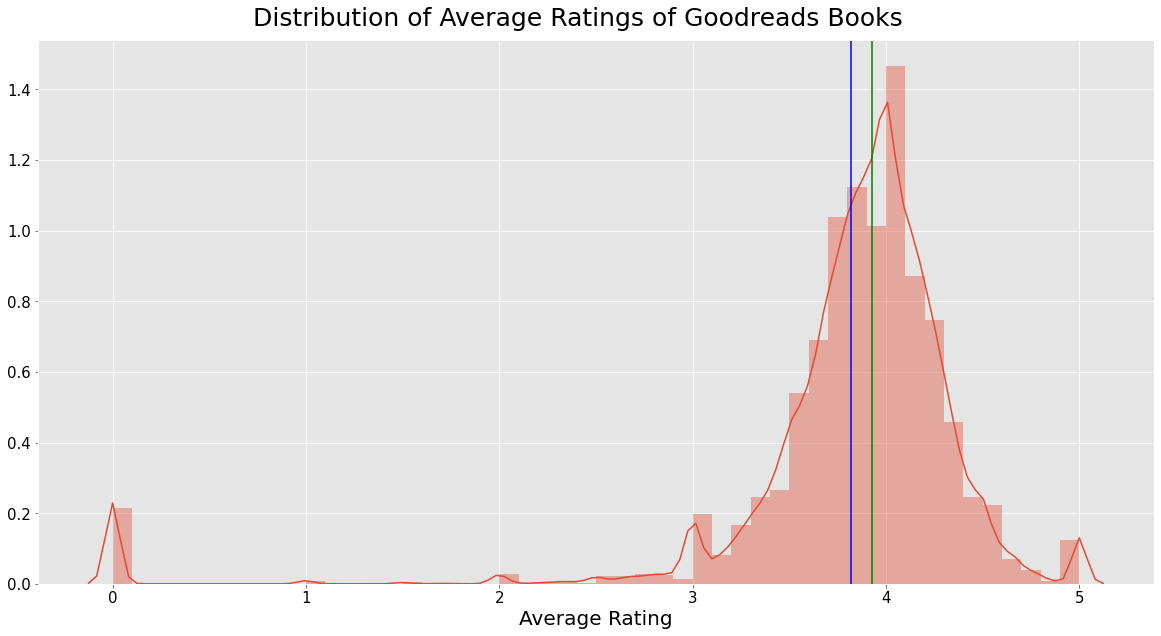

Unadjusted mean: 3.82
Unadjusted median: 3.93
Unadjusted variance: 0.48


In [7]:
# Before
plt.figure(figsize=(20,10))
sns.distplot(df['average_rating'])
plt.axvline(df['average_rating'].mean(), color='b')
plt.axvline(df['average_rating'].median(), color='g')

plt.figtext(.5,.9,'Distribution of Average Ratings of Goodreads Books', 
            fontsize=25, ha='center')
plt.xticks(fontsize=15, color='k')
plt.yticks(fontsize=15, color='k')
plt.xlabel('Average Rating', fontsize=20, color='k')
plt.show()

print('Unadjusted mean:', round(df['average_rating'].mean(), 2))
print('Unadjusted median:', round(df['average_rating'].median(), 2))
print('Unadjusted variance:', round(df['average_rating'].var(), 2))

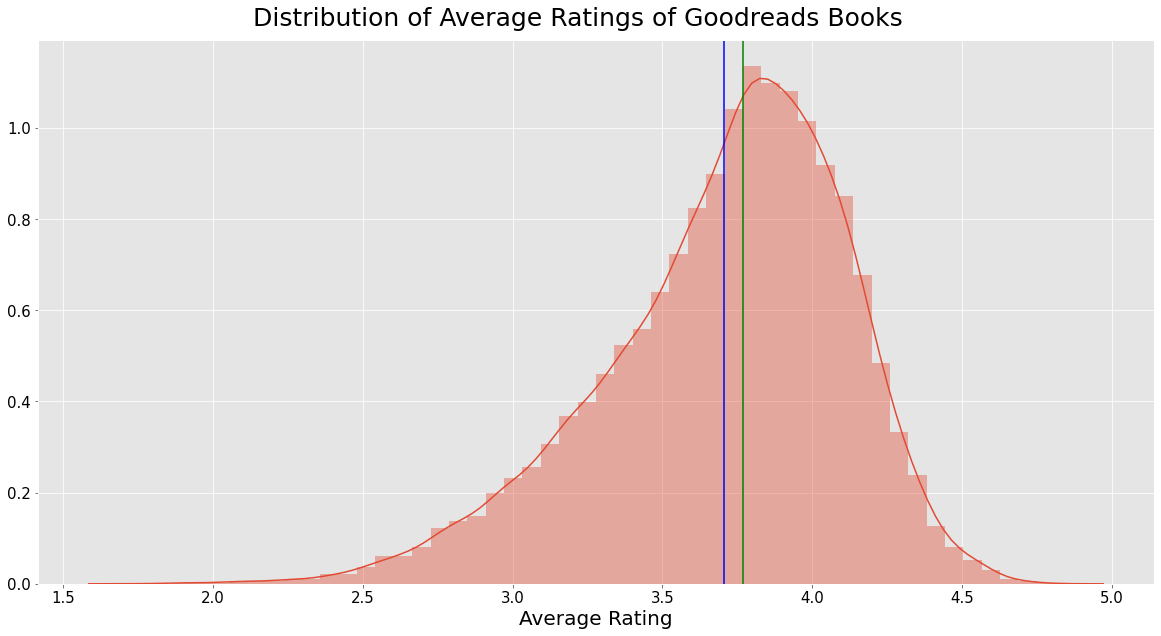

Adjusted mean: 3.71
Adjusted median: 3.77
Adjusted variance: 0.17


In [8]:
# After
plt.figure(figsize=(20,10))
sns.distplot(train['adjusted_average_rating'])
plt.axvline(train['adjusted_average_rating'].mean(), color='b')
plt.axvline(train['adjusted_average_rating'].median(), color='g')

plt.figtext(.5,.9,'Distribution of Average Ratings of Goodreads Books', 
            fontsize=25, ha='center')
plt.xticks(fontsize=15, color='k')
plt.yticks(fontsize=15, color='k')
plt.xlabel('Average Rating', fontsize=20, color='k')
plt.show()

print('Adjusted mean:', round(train['adjusted_average_rating'].mean(), 2))
print('Adjusted median:', round(train['adjusted_average_rating'].median(), 2))
print('Adjusted variance:', round(train['adjusted_average_rating'].var(), 2))

In [9]:
# Reexamine columns
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28976 entries, 0 to 41731
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   publication_year            25087 non-null  float64
 1   publication_month           23792 non-null  float64
 2   publication_day             23216 non-null  float64
 3   publisher                   25050 non-null  object 
 4   language_code               14289 non-null  object 
 5   average_rating              28976 non-null  float64
 6   num_pages                   23654 non-null  float64
 7   format                      24827 non-null  object 
 8   rating_dist                 28976 non-null  object 
 9   review_count                28976 non-null  int64  
 10  genres                      28976 non-null  object 
 11  author                      28976 non-null  object 
 12  title_length_in_characters  28976 non-null  int64  
 13  title_length_in_words       289

###   DATA LEAKAGE
Because our target is derived from ratings, training our model *using* ratings is effectively training with the target. To avoid distorting the model, we must drop these columns.

It is also possible that `review_count` is a bit of leakage, but it seems more like a proxy for *popularity*, not greatness, in the same way that pop(ular) songs are not often considered classics. Of course, we'll reconsider this if its permutation importance is suspiciously high.

In [10]:
leaky = ['average_rating', 'total_ratings', 
         'rating_dist', 'adjusted_average_rating']
train = train.drop(columns=leaky)

# Split Data
We'll do an 85/15 train-test split, then re-split our train set to make the validation set about the same size as the test set.

In [11]:
target = 'great'

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    train, train[target], test_size=0.15, 
    stratify=train[target], random_state=50)

                                                   
# Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1765, 
    stratify=X_train[target], random_state=50)

# Remove target
X_train = X_train.drop(columns=target)
X_val = X_val.drop(columns=target)
X_test = X_test.drop(columns=target)

# Check dimensions
# Test set size approximately equals val set size
print(X_train.shape, y_train.shape, X_val.shape, 
      y_val.shape, X_test.shape, y_test.shape)

(20281, 12) (20281,) (4348, 12) (4348,) (4347, 12) (4347,)


# Evaluation Metrics
With classes this imbalanced, accuracy (correct predictions / total predictions) can become misleading. There just aren't enough true positives for this fraction to be the best measure of model performance. So we'll also use ROC AUC, a Receiver Operator Characteristic Area Under the Curve. Here is a colored drawing of one, courtesy of Martin Thoma.
![Wikipedia image of ROC AUC curve](https://upload.wikimedia.org/wikipedia/commons/3/36/Roc-draft-xkcd-style.svg)

The ROC curve is a plot of a classification model's true positive rate (TPR) against its false positive rate (FPR). The ROC AUC is the area from [0, 1] under and to the right of this curve. Since optimal model performance maximizes true positives and minimizes false positives, the optimal point in this 1x1 plot is the top left, where the area under the curve (ROC AUC) = 1.

For imbalanced classes such as `great`, ROC AUC outperforms accuracy as a metric because it better reflects the relationship between true positives and false positives. It also depicts the classifier's performance across all its values, giving us more information about when and where the model improves, plateaus, or suffers.

# Fit Models
Predicting great books is a binary classification problem, so we need a classifier. Below, we'll encode, impute and fit to the data a linear model (Logistic Regression) and two tree-based models (Random Forests and XGBoost), then compare them to each other and to the majority baseline. We'll calculate their scoring metrics, accuracy and ROC AUC, and then make a visualization.
Majority Class Baseline

First, by construction, great books are the top 20% of books by adjusted rating. That means our majority class baseline (no books are great) has an accuracy of 80%.

Second, this "model" doesn't improve, plateau, or suffer since it has no discernment to begin with. A randomly chosen positive would be treated no differently than a randomly chosen negative. In other wrods, its ROC AUC = 0.5.

### Majority Class Baseline
First, by construction, great books are the top 20% of books by adjusted rating. That means our majority class baseline (*no* books are great) has an accuracy of 80%. 

Second, this "model" doesn't improve, plateau, or suffer since it has no discernment to begin with. A randomly chosen positive would be treated no differently than a randomly chosen negative. In other words, its ROC AUC = 0.5.

In [12]:
baseline_accuracy = round(train['great'].value_counts(normalize=True)[0], 4)

# Majority baseline is "No books are great", so make
# whole column of False (condition is never True)
maj_pred = y_val == 'a;sdlkfn' * len(y_val)
baseline_roc_auc = round(roc_auc_score(y_val, maj_pred), 4)

print('Baseline Validation Accuracy:', baseline_accuracy)
print('Baseline Validation ROC AUC:', baseline_roc_auc)   # 0.5 by definition

Baseline Validation Accuracy: 0.8
Baseline Validation ROC AUC: 0.5


/Users/RyanKoul/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


### Logistic Regression

In [13]:
lr = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    StandardScaler(), 
    LogisticRegressionCV(cv=20, n_jobs=-1, scoring='roc_auc', max_iter=1000)
)

lr.fit(X_train, y_train)
lr_roc_auc = round(lr.score(X_val, y_val), 4)

lr_pred = lr.predict(X_val)
lr_accuracy = round(accuracy_score(y_val, lr_pred), 4)

print('Baseline Validation Accuracy:', baseline_accuracy)
print('Logistic Regression Validation Accuracy:', lr_accuracy)
print('Baseline Validation ROC AUC:', baseline_roc_auc)
print('Logistic Regression Validation ROC AUC:', lr_roc_auc)

Baseline Validation Accuracy: 0.8
Logistic Regression Validation Accuracy: 0.8013
Baseline Validation ROC AUC: 0.5
Logistic Regression Validation ROC AUC: 0.6424


#### Logistic Regression Confusion Matrix
0 false positives, 863 false negatives. The model isn't flexible enough to capture the nonlinear relationship.

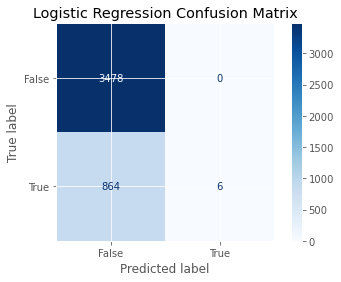

In [14]:
disp_lr = plot_confusion_matrix(lr, X_val, y_val,cmap=plt.cm.Blues)
disp_lr.ax_.set_title('Logistic Regression Confusion Matrix')

plt.show()

### Random Forest Classifier


In [15]:
rf = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_features=None)
)

rf.fit(X_train, y_train)
rf_accuracy = round(rf.score(X_val, y_val), 4)

rf_probs = rf.predict_proba(X_val)[:,1]   # All probs in 1d array
rf_roc_auc = round(roc_auc_score(y_val, rf_probs), 4)

print('Baseline Validation Accuracy:', baseline_accuracy)
print('Logistic Regression Validation Accuracy:', lr_accuracy)
print('Random Forest Validation Accuracy:', rf_accuracy)
print()
print('Majority Class Baseline ROC AUC:', baseline_roc_auc)
print('Logistic Regression Validation ROC AUC:', lr_roc_auc)
print('Random Forest Validation ROC AUC:', rf_roc_auc)

Baseline Validation Accuracy: 0.8
Logistic Regression Validation Accuracy: 0.8013
Random Forest Validation Accuracy: 0.8259

Majority Class Baseline ROC AUC: 0.5
Logistic Regression Validation ROC AUC: 0.6424
Random Forest Validation ROC AUC: 0.8021


#### Random Forest Confusion Matrix

Note: This has more a balance between false positives and false negatives because tree-based model have more flexibility than linear models.

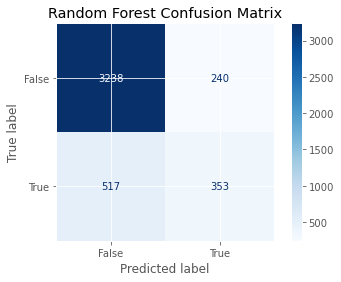

In [16]:
disp_rf = plot_confusion_matrix(rf, X_val, y_val, cmap=plt.cm.Blues)
disp_rf.ax_.set_title('Random Forest Confusion Matrix')

plt.show()

### XGBoost Classifier

In [17]:
gb = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=1000, n_jobs=-1, max_depth=13, learning_rate=0.1)
)

gb.fit(X_train, y_train)
gb_accuracy = round(gb.score(X_val, y_val), 4)

gb_probs = gb.predict_proba(X_val)[:,1]   # All probs in 1d array
gb_roc_auc = round(roc_auc_score(y_val, gb_probs), 4)

print('Baseline Validation Accuracy:', baseline_accuracy)
print('Logistic Regression Validation Accuracy:', lr_accuracy)
print('Random Forest Validation Accuracy:', rf_accuracy)
print('XGBoost Validation Accuracy:', gb_accuracy)
print()
print('Majority Class Baseline ROC AUC:', baseline_roc_auc)
print('Logistic Regression Validation ROC AUC:', lr_roc_auc)
print('Random Forest Validation ROC AUC:', rf_roc_auc)
print('XGBoost Validation ROC AUC', gb_roc_auc)

Baseline Validation Accuracy: 0.8
Logistic Regression Validation Accuracy: 0.8013
Random Forest Validation Accuracy: 0.8259
XGBoost Validation Accuracy: 0.8427

Majority Class Baseline ROC AUC: 0.5
Logistic Regression Validation ROC AUC: 0.6424
Random Forest Validation ROC AUC: 0.8021
XGBoost Validation ROC AUC 0.84


XGBClassifier performes the best in accuracy and ROC AUC.

In [18]:
# Now on test data
y_pred = gb.predict(X_test)
class_index = 1
y_pred_proba = gb.predict_proba(X_test)[:, class_index]

print('XGBoost Test Accuracy', round(accuracy_score(y_test, y_pred), 4))
print('XGBoost Test ROC AUC', round(roc_auc_score(y_test, y_pred_proba), 4))

XGBoost Test Accuracy 0.8456
XGBoost Test ROC AUC 0.8387


# Graph and Compare Models' ROC AUC

Below, we see that logistic regression lags far behind XGBoost and Random Forests in achieving a high ROC AUC. Among the top two, XGBoost initially outperforms RandomForest, and then the two roughly converge around FPR=0.6. We see in the lower right legend, however, that XGBoost has the highest AUC of 0.84, followed by Random Forest at 0.80 and Logistic Regression at 0.64.

In less technical language, the XGBoost model was the best at classifying great books as great (true positives) and not classifying not-great books as great (false positives). 

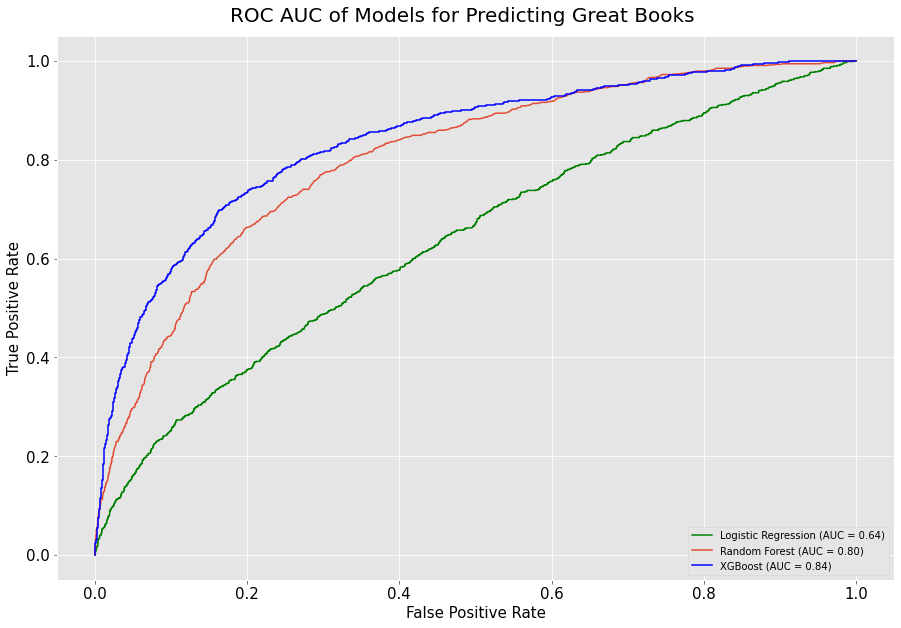

In [24]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15, 10))
plot_roc_curve(lr, X_test, y_test, name='Logistic Regression', color='g', ax=ax)
plot_roc_curve(rf, X_test, y_test, name='Random Forest', ax=ax)
plot_roc_curve(gb, X_test, y_test, name='XGBoost', color='b', ax=ax)

plt.figtext(.5,.9, 'ROC AUC of Models for Predicting Great Books', 
            fontsize=20, ha='center')
plt.xticks(fontsize=15, color='k')
plt.yticks(fontsize=15, color='k')
plt.xlabel('False Positive Rate', fontsize=15, color='k')
plt.ylabel('True Positive Rate', fontsize=15, color='k')

plt.show()

# Permutation Importances
One intuitive way of identifying whether and to what extent something is important is by seeing what happens when you take it away. This is the best in a situation unconstrained by time and money. 

But in the real world with real constrains, we can use permutation in stead. Instead of eliminating the column values values by dropping them, we eliminate the column's *signal* by randomizing it. If the column really were a predictive feature, the order of its values would matter, and shuffling them around would substantially dilute if not destroy the relationship. So if the feature's predictive power *isn't* really hurt or is even helped by randomization, we can conclude that it is not actually important.

Let's take a closer look at the permutation importances of our XGBoost model.

In [22]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer()
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

# Pull out model because that's what eli5 expects
model = XGBClassifier(n_estimators=1000, random_state=50, n_jobs=-1)
model.fit(X_train_transformed, y_train)


permuter = PermutationImportance(
    model, 
    scoring='roc_auc', 
    n_iter=5,           # run each permutation 5 times, then take average
    random_state=50)    # seed for reproducibility

permuter.fit(X_val_transformed, y_val)

feature_names = X_val.columns.tolist()
eli5.show_weights(permuter, 
                  top=None, 
                  feature_names=feature_names)

Weight,Feature
0.1925 ± 0.0171,review_count
0.0653 ± 0.0039,genres
0.0582 ± 0.0071,author
0.0411 ± 0.0033,num_pages
0.0363 ± 0.0038,title_length_in_characters
0.0067 ± 0.0027,publication_year
0.0060 ± 0.0031,title_length_in_words
0.0060 ± 0.0024,publisher
0.0049 ± 0.0012,format
0.0049 ± 0.0025,language_code


### Permutation Importance Analysis
As we assumed at the beginning, `review_count` matters but it is not suspiciously high. This does not seem to rise to the level of data leakage. 

We see that `genres` is the second most important feature for ROC AUC in the XGBoost model. 

`author` is third, which is surprising and perhaps a bit concerning. Because our test set is small, the model may just be identifying authors whose books are the most highly rated in wilson-adjusted terms, such as J.K. Rowling and Suzanne Colins. More data would be useful to test this theory.

Fourth is `num_pages`. I thought this would be higher for two reasons:
   1. Very long books' ratings seem to have a bit of a ratings bias upward in that people willing to start and finish them will rate them higher. The long length screens out less interested marginal readers, who probably wouldn't have rated the book highly in the first place. 
   2. Reading and showing off that you're reading or have read long books is a sign of high social status. The archetypal example: Infinite Jest.
